# <span style="color:#9c8f8f"> 75.06/95.58 Organización de Datos</span>
# <span style="color:#9c8f8f"> Análisis exploratorio: Real or Not? NLP with Disaster Tweets</span>

# <center>FEATURE ENGINEERING</center>
# <center>Random Forest</center>

In [1]:
# Cargo librerias

import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.model_selection import train_test_split

# I) Auxiliary Functions

In [78]:
#Analisis de features y la importancia de c/u
def get_eficiencia_features_de (df, cantidad_arboles, profundidad_cada_arbol):
    # "desde_col" toma la columna desde la cual se van a evaluar los features
    # "hasta_col" toma la columna hasta la cual se van a evaluar los features
    # "on_col" toma la unica columna para la cual se van a calcular los features que van entre (desde_col,hasta_col)
    vector_aux = []
    on_col = 1
    desde_col = on_col + 1
    hasta_col = -1 
    #X,y = df.iloc[:,1:7] , df.iloc[:,1]
    X,y = df.drop(columns=["target","id"]) , df.target
    X_train, X_test, y_train, y_test = train_test_split (X,y, test_size=0.2, random_state = 123)
    rf_model = RandomForestClassifier(random_state = 1, n_estimators = cantidad_arboles, max_depth = profundidad_cada_arbol)
    rf_model.fit(X_train,y_train)
    predicciones = rf_model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test,predicciones)) 
    feature_importances = rf_model.feature_importances_
    feature_estimators = rf_model.estimators_[0]
    vector_aux.append(X_train)
    vector_aux.append(rmse)
    vector_aux.append(feature_importances)
    vector_aux.append(feature_estimators)
    return vector_aux

In [101]:
#Plot de feature importance con RF
def bar_plot_feature_importance (X_train, feature_importance,lenght,width, font):
    plt.bar(X_train.columns, feature_importance.Importance)
    plt.xlabel ('features', fontsize = font)
    plt.ylabel ('importancia', fontsize = font)
    plt.title ('Feature importance con RF', fontsize = font)
    plt.rcParams["figure.figsize"] = (lenght,width)
    plt.xticks(rotation='vertical', fontsize = 14)
    plt.show()

In [80]:
#Plot de grafica de estimadores y diagrama de arbol
def bar_plot_feature_estimators (X_train, feature_estimators):
    plt.bar(X_train.columns, feature_estimators.feature_importances_)
    plt.xlabel('features')
    plt.ylabel('importancia')
    plt.title('importancia features del arbol')
    plt.xticks(rotation='vertical')
    plt.show
    fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize=(10,10), dpi = 200)
    tree.plot_tree(feature_estimators, feature_names = X_train.columns, filled = True)

In [5]:
#Standariza a cierto formato los csv input
def csv_to_df_standarized(doc_csv):
    df = pd.read_csv(doc_csv)
    if df.columns[0] == 'Unnamed: 0':
        df = df.drop(df.columns[0],axis=1)
    return df

In [6]:
#Toma todos los csv con features numericos y los procesa
def analisis_de_todos_los_features_numericos(docs):
    for doc in docs:
        df_actual = csv_to_df_standarized(doc)
        vectorcito_actual = get_eficiencia_features_de(df_actual,3,6)
        print('RMSE: %f' % vectorcito_actual[1])
        puntaje_ordenado_descendente = np.sort(vectorcito_actual[2])[::-1]
        print(puntaje_ordenado_descendente[:20])
        bar_plot_feature_importance(vectorcito_actual[0],puntaje_ordenado_descendente)
        #bar_plot_feature_importance(vectorcito_actual[0],vectorcito_actual[2])
        bar_plot_feature_estimators(vectorcito_actual[0],vectorcito_actual[3])

In [7]:
#Guarda los features mas importantes y los valores de feature_importance
def feature_importance_chart(X_train,feature_importance):
    featureImpList= []

    for feat, importance in zip(X_train.columns, feature_importance):  
        temp = [feat, importance*100]
        featureImpList.append(temp)

    fT_df = pd.DataFrame(featureImpList, columns = ['Feature', 'Importance'])
    final = fT_df.sort_values('Importance',ascending = False)
    return final

In [8]:
#Devuelve el numero de columna que representa el feature mas importante - de mayor a menor
def col_number_by_feature_importance_descending(feature_importance):
    important_features_dict = {}
    for x,i in enumerate(feature_importance):
        important_features_dict[x]=i


    important_features_list = sorted(important_features_dict,
                                     key=important_features_dict.get,
                                     reverse=True)
    resultado = ('Most important features: %s' %important_features_list)
    return resultado


In [9]:
def csv_final_test_and_train(importance_features_chart,cant_features,train_set,test_set):
    importance_features_chart = importance_features_chart.iloc[0:cant_features,]
    lista_columnas_elegidas = importance_features_chart['Feature'].to_list()
    lista_columnas_elegidas.append("id")
    termino = ['target']
    lista_columnas_elegidas_train = (lista_columnas_elegidas + termino)
    
    final_test = test_set[test_set.columns.intersection(lista_columnas_elegidas)]
    final_train = train_set[train_set.columns.intersection(lista_columnas_elegidas_train)]
    return (final_train, final_test)

In [10]:
def standarize_multiple_dataframes(lista_dataframes):
    lista_df_standarized = []
    for df in lista_dataframes:
        df_standarized = csv_to_df_standarized(df)
        lista_df_standarized.append(df_standarized)
    return lista_df_standarized

# II) Random Forest

## a. TRAIN SET

In [23]:
# Levantamos el df con features finales a evaluar
df = pd.read_csv('FEATURES_TRAIN_FINAL.csv')
df = df.drop(columns = ['Unnamed: 0','text'])
df = df.fillna(0)

In [24]:
df.head()

,id,target,#palabras,#palabras_unicas,#caracteres,#stopwords,#puntuacion,#capitalize,#mayusculas,promedio_len_word,...,text_contains_keyword,has_keyword,keywords_quantity,keywords_mean,keyword_is_hashtag,keyword_frequency,#hashtags,has_hashtag,links_cant,cant_failed_links
0,1,1,13,13,71,5,1,5,1,4.384615,...,1,1,1,0.004525,1,0.227027,1,1,0.0,0.0
1,4,1,7,7,40,0,1,5,0,4.571429,...,1,1,1,0.004525,0,0.237838,0,0,0.0,0.0
2,5,1,22,20,135,9,3,2,0,5.090909,...,1,1,1,0.004525,0,0.210811,0,0,0.0,0.0
3,6,1,8,8,67,1,2,1,0,7.125000,...,1,1,1,0.004525,0,0.210811,1,1,0.0,0.0
4,7,1,16,15,90,6,2,3,0,4.500000,...,1,1,1,0.004525,0,0.237838,2,1,0.0,0.0


In [62]:
#original de todos 127,70
vector_train_set = get_eficiencia_features_de(df,130,50)

In [81]:
train_set_feature_importance = feature_importance_chart(vector_train_set[0],vector_train_set[2])
train_set_feature_importance.describe()

,Importance
count,28.000000
mean,3.571429
std,3.183304
min,0.000000
25%,1.285946
50%,2.364262
75%,5.014940
max,12.989222


In [99]:
train_set_feature_importance.head(15)

,Feature,Importance
7,promedio_len_word,12.989222
23,keyword_frequency,10.203674
2,#caracteres,9.336468
5,#capitalize,5.978749
3,#stopwords,5.671200
1,#palabras_unicas,5.318390
0,#palabras,5.198495
21,keywords_mean,4.953755
8,#caracteres_especiales,4.524147
4,#puntuacion,4.451941


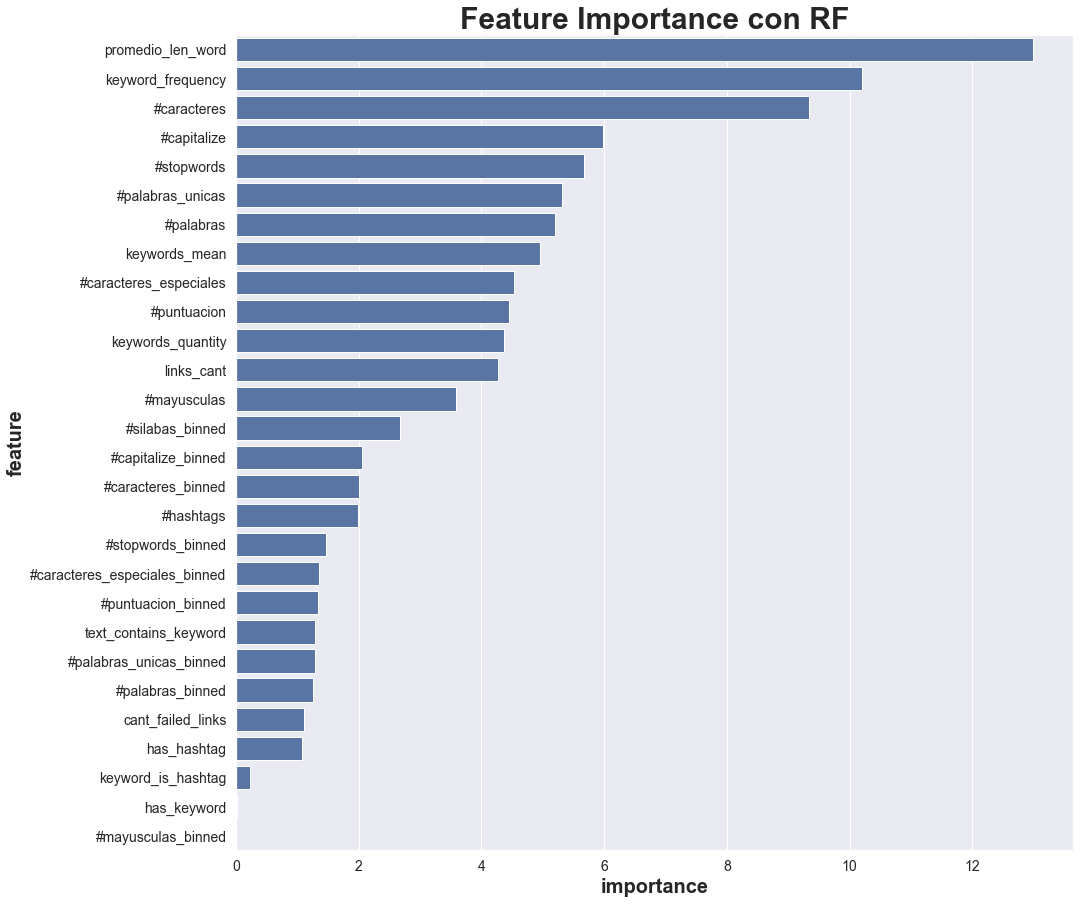

In [141]:
# GRAFICA DE FEATURE IMPORTANCE CON RADOM FOREST
import seaborn as sns
g = sns.barplot(x="Importance",y='Feature', data=train_set_feature_importance, color="b")
g.axes.set_title("Feature Importance con RF",fontsize=30, fontweight='semibold')
g.set_xlabel("importance",fontsize=20, fontweight='semibold')
g.set_ylabel("feature",fontsize=20, fontweight='semibold')
g.tick_params(labelsize=14)
sns.set(rc={'figure.figsize':(15,15)})